In [2]:
import rosbag
from sensor_msgs.msg import Image
from cv_bridge import CvBridge

import numpy as np
import cv2
import matplotlib.pyplot as plt

from copy import deepcopy

In [8]:
def save_frames(topic, image, color_frame_start, depth_frame_start, length):
    bridge = CvBridge()
    # color frame
    if topic == "/camera/color/image_raw":
        if color_frame_start <= image.header.seq < color_frame_start + length:
            color_image = bridge.imgmsg_to_cv2(image, "bgr8")
            cv2.imwrite("color_frames/color_image" + str(image.header.seq) + ".png", color_image)
            print("color_image" + str(image.header.seq) + ".png")
    # depth frame
    elif topic == "/camera/aligned_depth_to_color/image_raw":
        if depth_frame_start <= image.header.seq < depth_frame_start + length:
            depth_image = bridge.imgmsg_to_cv2(image)
            cv2.imwrite("depth_frames/depth_image" + str(image.header.seq) + ".png", depth_image)
            print("depth_image" + str(image.header.seq) + ".png")


In [9]:
# Read rosbag
read_bag_filename = "/home/kodogyu/Datasets/rosbags/l515_aligned_stereo2.bag"
read_bag = rosbag.Bag(read_bag_filename)

topics = ['/camera/color/image_raw', '/camera/aligned_depth_to_color/image_raw']

# bag_generator = read_bag.read_messages(topics=topics)
for topic, image, t in read_bag.read_messages(topics=topics):
    save_frames(topic, image, color_frame_start=484, depth_frame_start=213, length=1)
# depth_topic, depth_image_message, t_depth = next(bag_generator)
# color_topic, color_image_message, t = next(bag_generator)

read_bag.close()

color_image484.png
depth_image213.png


In [16]:
read_bag_filename = "/home/kodogyu/Datasets/PAIR360/calibration/cam1/rotated_bag/orign_1_rotated.bag"
# read_bag_filename = "/home/kodogyu/Datasets/PAIR360/calibration/cam1/origin_1_5fps.bag"
# read_bag_filename = "/home/kodogyu/Datasets/PAIR360/calibration/cam1/origin_1_comp.bag"
read_bag = rosbag.Bag(read_bag_filename)

topics = ['/camera/image_raw']
# topics = ['camera/image_raw/compressed']

bag_generator = read_bag.read_messages(topics=topics)
topic, image, t = next(bag_generator)

In [17]:
bridge = CvBridge()
# cv2_img = bridge.compressed_imgmsg_to_cv2(image, "bgr8")
cv2_img = bridge.imgmsg_to_cv2(image)

print(cv2_img.shape)

(3840, 2880, 3)


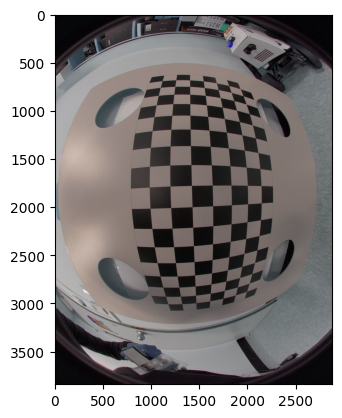

In [18]:
plt.imshow(cv2_img)
plt.show()

2


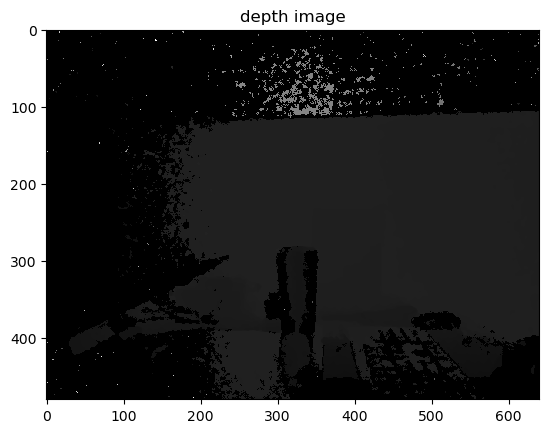

In [15]:
bridge = CvBridge()
color_image = bridge.imgmsg_to_cv2(color_image_message)
depth_image = bridge.imgmsg_to_cv2(depth_image_message)

print(depth_image.ndim)

plt.title('depth image')
plt.imshow(depth_image, cmap='gray')
plt.show()

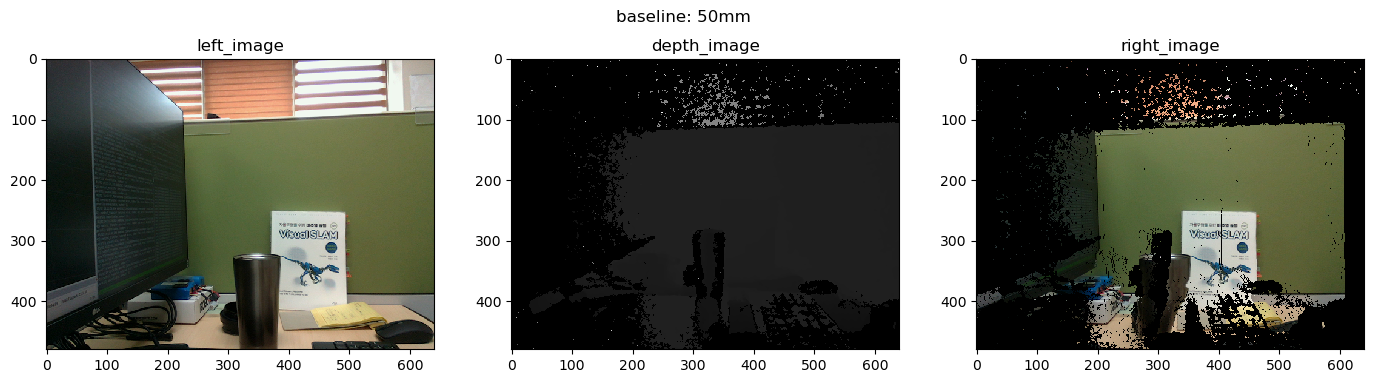

In [18]:
# Basic information
focal_length = 604  # f_x = 603.838, f_y = 604.019
baseline = 10  # 10mm
right_image = np.zeros_like(color_image)

# Calculate the right image
for row in range(480):
    for col in range(640):
        depth = depth_image[row, col]  # mm
        if depth:
            disparity = focal_length * baseline // depth
            
            if (col - disparity > 0):
                right_image[row, col - disparity] = color_image[row, col]

# Plot
figure, axs = plt.subplots(1, 3, figsize=(17, 4))
figure.suptitle('baseline: ' + str(baseline) + "mm")
axs[0].imshow(color_image)
axs[0].set_title('left_image')
axs[1].imshow(depth_image, cmap='gray')
axs[1].set_title('depth_image')
axs[2].imshow(right_image)
axs[2].set_title('right_image')

plt.show()


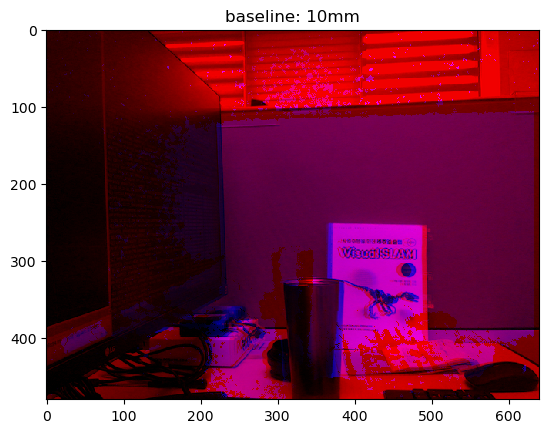

In [103]:
display_image = np.zeros_like(color_image)
display_image[:, :, 0] = color_image[:, :, 0]  # R
display_image[:, :, 2] = right_image[:, :, 2]  # B


plt.imshow(display_image)
plt.title('baseline: ' + str(baseline) + 'mm')
plt.show()

In [104]:
# Write rosbag
write_bag = rosbag.Bag('test_rosbags/test.bag', 'w')

try:
    right_image_message = bridge.cv2_to_imgmsg(right_image, "rgb8")
    right_image_message.header = deepcopy(color_image_message.header)
    right_image_message.header.frame_id = "camera_color_optical_right_frame"

    write_bag.write('/camera/color_right/image_raw', right_image_message)
    write_bag.write('/camera/color/image_raw', color_image_message)
finally:
    write_bag.close()